## 线下零售贷款申请客户特征处理-申请信息特征

In [1]:
import pandas as pd
from feature_selector import FeatureSelector
import matplotlib.pyplot as plt
import numpy as np
import pylab
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
import math
import datetime
import scorecardpy as sc
import scipy
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score,train_test_split
import seaborn as sns
import warnings
from sklearn.metrics import roc_auc_score,roc_curve

%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False  
pd.set_option('max.columns',200)
warnings.filterwarnings('ignore')

In [2]:
apply_data = pd.read_excel('线下零售贷款申请-衍生.xls')

In [3]:
apply_data = apply_data.iloc[:,1:]

# 数据清洗

In [4]:
apply_data = apply_data[~apply_data['产品小类'].fillna('N').str.contains('房E贷|小微E贷|税享贷|E车贷|兴安贷')]
missing_ratio = 1-(apply_data.count()/len(apply_data))
drop_feas = missing_ratio[missing_ratio>0.8].index

In [5]:
drop_feas

Index(['上报评审时间总行', '低风险总金额', '类低总金额', '共同借款人编号', '共同借款人名称', '是否有保证', '是否保证加抵押',
       '年龄', '户籍与居住市级是否一致', '户籍与居住区级是否一致', '配偶年龄', '配偶是否有单位记录',
       '本人居信住址是否与配偶住址', '客户性质', '控股类型'],
      dtype='object')

In [6]:
apply_data.drop(drop_feas,axis=1,inplace=True)

In [7]:
apply_data['产品小类'].unique()

array(['筑梦贷', '个人经营贷款', '其他消费贷款', '耐用消费品', '个人住房装修贷款', '个人住房装修',
       '个人商用房按揭（二手）', '个人商用房按揭（一手现房）', '个人住宅按揭（二手）', '个人住房装修贷款,耐用消费品',
       '车位贷款', '个人住房装修贷款,其他消费贷款', '购买家用车', nan, '自助质押消费贷', '个人住宅按揭（一手现房）',
       '个人住宅按揭（一手期房）', '个人信保贷', '个人商用房按揭（一手期房）'], dtype=object)

# 一、特征初步衍生

## 1.保证、质押特征

In [8]:
apply_data['是否有保证'] = apply_data['保证人客编'].apply(lambda x:0 if np.isnan(x) else 1)
apply_data['是否保证加抵押'] = apply_data[['押品类型','是否有保证']].apply(
    lambda x:1 if (x[0] != np.nan)&(x[1] == 1) else 0,axis=1)

## 2.年龄相关

In [9]:
apply_data['起始日'] = pd.to_datetime(apply_data['起始日'])
apply_data['birth_year'] = apply_data['借款人身份证'].apply(lambda x:int(x[6:10]) if len(x) == 18 else np.nan)
apply_data['年龄'] = apply_data['起始日'].dt.year - apply_data['birth_year']

## 3.地址相关

In [10]:
def trans_dist(x):
    if x // 1000 in [310,110,300,500]:
        return (x // 1000)*1000
    else:
        return (x // 100)*100

apply_data['birth_region'] = apply_data['户籍地行政区划'].apply(trans_dist)
apply_data['resdnt_region'] = apply_data['居住地行政区划'].apply(trans_dist)
apply_data['户籍地与居住地市级是否一致'] = (apply_data['birth_region']==apply_data['resdnt_region']).astype(int)
apply_data['户籍地与居住地区级是否一致'] = (apply_data['户籍地行政区划']==apply_data['居住地行政区划']).astype(int)

In [11]:
apply_data[['户籍地行政区划','居住地行政区划','户籍地与居住地市级是否一致','户籍地与居住地区级是否一致']].head()

,户籍地行政区划,居住地行政区划,户籍地与居住地市级是否一致,户籍地与居住地区级是否一致
0,350205.0,350205.0,1,1
1,350205.0,350205.0,1,1
2,310115.0,310115.0,1,1
3,350681.0,350206.0,0,0
4,350213.0,350212.0,1,0


## 4.配偶相关

In [12]:
apply_data['配偶年龄'] = apply_data['起始日'].dt.year - apply_data['配偶身份证'].astype(str).apply(
    lambda x: int(x[6:10]) if len(x) == 18 else np.nan)

In [13]:
apply_data['配偶是否有单位记录'] = apply_data['单位性质.1'].where(apply_data['单位性质.1'].isnull(),1).fillna(0)

In [14]:
apply_data[['单位性质.1','配偶是否有单位记录']].head() 

,单位性质.1,配偶是否有单位记录
0,NaN,0
1,NaN,0
2,NaN,0
3,NaN,0
4,NaN,0


In [15]:
apply_data['本人居住地址是否与配偶住址一致'] = apply_data[['居住地行政区划','居住地行政区划.2']].apply(lambda x:1 if x[0]==x[1] else 0,axis=1)

## 5.其他衍生

In [16]:
apply_data['work_place_equal_birth_place'] = (apply_data['PROVINCE_CITY'] == apply_data['户籍地行政区划']).astype(int)
apply_data['work_place_equal_resdnt_place'] = (apply_data['PROVINCE_CITY'] == apply_data['居住地行政区划']).astype(int)

In [17]:
apply_data['rep_name_equal_ctrl_name'] = (apply_data['法定代表人'] == apply_data['实际控制人']).astype(int)

In [18]:
apply_data['成立日期'] = pd.to_datetime(apply_data['成立日期'])
apply_data['found_until_apply_days'] = (apply_data['起始日']-apply_data['成立日期']).dt.days
apply_data['found_until_apply_years'] = round((apply_data['起始日']-apply_data['成立日期']).dt.days/365)
apply_data['found_until_apply_month'] = round((apply_data['起始日']-apply_data['成立日期']).dt.days/30)

In [19]:
apply_data['性别'].replace({'男性':1,'女性':0},inplace=True)

# 二.样本打标与特征整合

In [20]:
# bad_tag = pd.read_csv('bad_acct_no.csv')
# main_cust = pd.read_csv('main_cust_no_2.csv')
# zx_feas = pd.read_excel('征信特征汇总.xlsx')

# main_cust = main_cust.drop_duplicates()
# main_cust.columns = ['授信申请编号','客户编号','基准时间','原始交易编号']
# main_fea = apply_data[apply_data['授信申请编号'].isin(main_cust['授信申请编号'])]
# main_cust['tag'] = 0
# main_cust.loc[main_cust['原始交易编号'].isin(bad_tag['acct_no']),'tag'] = 1
# del main_cust['原始交易编号']
# main_cust = main_cust.drop_duplicates()

# zx_feas.rename(columns={'DATE':'基准时间'},inplace=True)
# main_cust.rename(columns={'base_time':'基准时间','cust_no':'客户编号','apply_no':'授信申请编号'},inplace=True)

# main_cust = main_cust.merge(zx_feas,on=['客户编号','基准时间'],how='left').drop_duplicates()

# main_cust_fir = main_cust.sort_values(['授信申请编号','基准时间']).groupby('授信申请编号').first()
# main_cust_fir.dropna(subset=['tag'],inplace=True)
# main_cust_tag = main_cust.groupby('授信申请编号')[['tag']].max()
# main_cust_fir.drop(['tag'],axis=1,inplace=True)
# main_cust = main_cust_fir.merge(main_cust_tag,right_index=True,left_index=True)
# del main_cust_fir
# del main_cust_tag
# main_cust = main_cust.reset_index('授信申请编号')
# main_cust.drop(['客户编号','年龄','用款主体客编','婚姻状况','配偶客编'],axis=1,inplace=True)
# main_cust = main_cust.dropna(subset=['cert_no'])
# main_dataset = main_cust.merge(apply_data,on=['授信申请编号'],how='inner').drop_duplicates()

# main_dataset = main_dataset.drop(['客户编号','贷款用途','到期日','客户名称','上报评审时间分行','评审出具意见时间',
#                           '产品小类','评估价值币种','保证人客户名称','籍贯','办公行政区划','户籍地行政区划',
#                           '居住地行政区划.1','户籍地地行政区划','办公行政区划.2','配偶客户名称',
#                           '注册地行政区划','居住地行政区划.3','办公行政区划.1','户籍地地行政区划.1','籍贯.1','性别.1','实际控制人',
#                           '法定代表人', '注册资本币种','CCNAME','GUARANTY_TYPE','INDIV_COM_TYP.1','INDIV_COM_TYP'],axis=1)
# def unique_handle(x):
#     xn = x.head(1)
#     xn['担保金额.1'] = x['担保金额.1'].unique().sum()
#     xn['评估价值'] = x['评估价值'].unique().sum()
#     return xn

# main_dataset = main_dataset.groupby('授信申请编号').apply(unique_handle)
# main_dataset = main_dataset.reset_index(level=0,drop=True)

# main_dataset['tag'].value_counts()

In [21]:
# main_dataset.to_csv('main_fea_origin_2.csv',index=False,encoding='gbk')

In [32]:
# 旧代码
bad_tag = pd.read_csv('bad_acct_no.csv')
main_cust = pd.read_csv('main_cust_no_3.csv')
zx_feas = pd.read_excel('征信特征汇总2.xlsx')
# grey_cust = pd.read_csv('grey_cust.csv')

In [33]:
zx_feas.drop(['性别'],axis=1,inplace=True)
main_cust = main_cust.drop_duplicates()
main_cust.columns = ['授信申请编号','客户编号','基准时间','原始交易编号']
main_fea = apply_data[apply_data['授信申请编号'].isin(main_cust['授信申请编号'])]
# main_cust = main_cust[~main_cust['原始交易编号'].isin(grey_cust['acct_no'])]
main_cust['tag'] = 0
main_cust.loc[main_cust['原始交易编号'].isin(bad_tag['acct_no']),'tag'] = 1
del main_cust['原始交易编号']
main_cust = main_cust.drop_duplicates()

# main_cust_tag = main_cust.groupby('授信申请编号')[['tag']].max().reset_index()

zx_feas.rename(columns={'DATE':'基准时间'},inplace=True)
main_cust.rename(columns={'base_time':'基准时间','cust_no':'客户编号','apply_no':'授信申请编号'},inplace=True)

main_cust = main_cust.merge(zx_feas,on=['客户编号','基准时间'],how='left').drop_duplicates()

main_cust = main_cust.sort_values(['授信申请编号','tag'],ascending=[True,False]).groupby('授信申请编号',as_index=False).first()

In [34]:
main_cust.drop(['客户编号','年龄','婚姻状况','配偶客编'],axis=1,inplace=True)
# apply_data.drop('性别','婚姻状况',axis=1,inplace=True)

main_dataset = main_cust.merge(apply_data,on=['授信申请编号'])
main_dataset = main_dataset.drop_duplicates()

# main_cust.to_excel('all_model_data.xlsx',index=False)

main_dataset = main_dataset.drop(['客户编号','贷款用途','到期日','客户名称','上报评审时间分行','评审出具意见时间',
                          '产品小类','评估价值币种','保证人客户名称','籍贯','籍贯.1','性别.1','实际控制人',
                          '法定代表人', '注册资本币种','CCNAME','GUARANTY_TYPE','办公行政区划','居住地行政区划.1',
                          '户籍地地行政区划','办公行政区划.1','居住地行政区划.3','户籍地地行政区划.1','办公行政区划.2',
                          '办公行政区划.2','注册地行政区划','INDIV_BRT_PLACE.1','INDIV_BRT_PLACE','PROVINCE_CITY','PROVINCE_CITY.1',
                          'PROVINCE_CITY.2','INDIV_COM_TYP','INDIV_COM_TYP.1','INDIV_COM_TYP','birth_region','resdnt_region',
                         '婚姻状况.1'],axis=1)

# main_dataset.to_excel('main_fea_origin.xlsx',index=False)

def unique_handle(x):
    xn = x.head(1)
    xn['担保金额.1'] = x['担保金额.1'].unique().sum()
    xn['评估价值'] = x['评估价值'].unique().sum()
#     xn.drop('授信申请编号',axis=1,inplace=True)
    return xn

main_dataset = main_dataset.groupby('授信申请编号').apply(unique_handle)
main_dataset = main_dataset.reset_index(level=0,drop=True)
main_dataset = main_dataset.dropna(subset=['证件号码'])

In [35]:
main_dataset['tag'].value_counts()

0    3789
1      11
Name: tag, dtype: int64

In [36]:
main_dataset.shape

(3800, 241)

In [37]:
main_dataset.to_csv('main_fea_origin_drop_grey.csv',index=False,encoding='gbk')

# 三、特征深度加工

## 1.超过5个分类的类别特征编码

In [27]:
# 输出类别变量及其对应的分类个数
def get_features_type(xfea):
    types_ser = xfea.dtypes
    cat_feas = types_ser[(types_ser == object)|(types_ser == str)].index
    cat_feas_dic = {c: len(xfea[c].unique()) for c in cat_feas}
    num_feas = types_ser[(types_ser==float)].index
    num_feas_dic = {n: len(xfea[n].unique()) for n in num_feas if len(xfea[n].unique()) >= 3}
    return {'cat_feas':pd.Series(cat_feas_dic),'num_feas':pd.Series(num_feas_dic)}

# 分类大于5个的类别变量进行bad_rate 编码(会把没有坏样本的区间合并)
def BadRateEncoding(df, col, target):
    '''
    :param df: dataframe containing feature and target
    :param col: the feature that needs to be encoded with bad rate, usually categorical type
    :param target: good/bad indicator
    :return: the assigned bad rate to encode the categorical feature
    '''
    bin_dict,regroup = BinBadRate(df, col, target)
    br_dict = regroup[[col,'badrate']].set_index([col])['badrate'].to_dict()
    return br_dict,regroup

def BinBadRate(df, col, target,return_type='badrate'):
    '''
    :param df: 需要计算好坏比率的数据集
    :param col: 需要计算好坏比率的特征
    :param target: 好坏标签
    :param grantRateIndicator: 1返回总体的坏样本率，0不返回
    :return: 每箱的坏样本率，以及总体的坏样本率（当grantRateIndicator＝＝1时）
    '''
    regroup = df.groupby([col])['tag'].agg(['count','sum'])# 每箱的坏样本数，总样本数
    regroup.columns = ['total','bad']
    regroup.reset_index(level=0, inplace=True)
    regroup['good'] = regroup['total'] - regroup['bad']
    regroup['badrate'] = regroup['bad']/regroup['total']
    regroup['badattr'] = regroup['bad']/regroup['bad'].sum()
    regroup['goodattr'] = regroup['good']/regroup['good'].sum()
    regroup['woe'] = np.log(regroup['badattr']) - np.log(regroup['goodattr'])
    regroup['bin_iv'] = (regroup['badattr'] - regroup['goodattr'])*regroup['woe']
    regroup['total_iv'] = regroup.loc[(regroup['bin_iv'] != np.inf) | (regroup['bin_iv'] != np.inf),'bin_iv'].sum()
    if return_type == 'badrate':
        dicts = dict(zip(regroup[col],regroup['badrate'])) # 每箱对应的坏样本率组成的字典
    else:
        dicts = dict(zip(regroup[col],regroup['woe'].replace({-np.inf:0,np.inf:0})))
    return dicts, regroup

def BinWoeEncoding(df,col,target):
    woebin_dict,bin_df = regroup = BinBadRate(df, col, target, return_type='woe')
    return woebin_dict,bin_df

In [28]:
train_dt = main_dataset[main_dataset['基准时间'] <= '2019-09-30']
test_oot = main_dataset[main_dataset['基准时间'] > '2019-09-30']

In [29]:
train_dt = train_dt.loc[:,~train_dt.columns.str.contains('客编')]
test_oot = test_oot.loc[:,~test_oot.columns.str.contains('客编')]
# 查看数据缺失比例,删除缺失超过85%的特征
fs = FeatureSelector(data=main_dataset.drop(['tag'],axis=1), labels=main_dataset['tag'])
fs.identify_missing(0.8)
train_dt = train_dt.drop(fs.ops['missing'],axis=1)
test_oot = test_oot.drop(fs.ops['missing'],axis=1)

54 features with greater than 0.80 missing values.



In [30]:
tra_x,test_x,tra_y,test_y = train_test_split(train_dt,train_dt['tag'],test_size=0.2,stratify=train_dt['tag'],random_state=123)
test_x['oot'] = 0
test_oot['oot'] = 1
test_x = pd.concat([test_x,test_oot],axis=0)
test_y = pd.concat([test_y,test_oot['tag']],axis=0)

In [31]:
test_x['tag'].value_counts()

0    2749
1      89
Name: tag, dtype: int64

In [32]:
test_x.shape

(2838, 185)

In [33]:
tra_x['tag'].value_counts()

0    3130
1     186
Name: tag, dtype: int64

In [34]:
tra_x.shape

(3316, 184)

In [35]:
# tra_x.to_csv('tra_x.csv',index=False)
# tra_y.to_csv('tra_y.csv',index=False)
# test_x.to_csv('test_x.csv',index=False)
# test_y.to_csv('teat_y.csv',index=False)

In [36]:
drop_feas = ['基准时间','配偶证件号码_y','mr_婚姻状况','mr_年龄','行业大类（可否聚类分析）','单位性质.1','最高学历.1','雇佣状态.1',
             '用款主体客户名称','发证日期','行业大类','单位所属行业.1']
tra_x.drop(drop_feas,axis=1,inplace=True)
test_x.drop(drop_feas,axis=1,inplace=True)

In [37]:
all_feas_info = get_features_type(tra_x)
cat_feas = all_feas_info['cat_feas']
num_feas = all_feas_info['num_feas']
cat_feas_1 = cat_feas[(cat_feas>6)&(cat_feas<100)]
cat_feas_2 = cat_feas[cat_feas <= 6]

In [38]:
cat_feas_1

担保方式     8
押品类型    17
单位性质    17
最高学历    10
雇佣状态     7
dtype: int64

In [39]:
cat_feas_2

主担保方式       4
项目类型        4
是否可循环       2
是否有共同借款人    2
还款方式        5
评估类型        3
保证形式        4
婚姻状况        6
企业规模        4
dtype: int64

In [40]:
# 对类别超过5小于100的分类变量进行bad rate编码，转化为数值变量后分箱
bin_dicts = {}
bin_df_dicts = {}
for c in cat_feas_1.index:
    bin_dict,bin_df = BadRateEncoding(tra_x,c,target='tag')
    bin_dicts[c] = bin_dict
    bin_df_dicts[c] = bin_df
tra_x.replace(bin_dicts,inplace=True)
test_x.replace(bin_dicts,inplace=True)

In [41]:
for c in cat_feas_1.index:
    print(c,bin_df_dicts[c]['total_iv'][0])

担保方式 0.15046580618607483
押品类型 0.09204243620155177
单位性质 0.06103381998684328
最高学历 0.09451335507579967
雇佣状态 0.039731716441362766


In [42]:
test_x['押品类型'].replace({'酒店':0,'家用车辆':0},inplace=True)

In [43]:
# # 对类别小于3的分类变量进行label编码(可选)
# for c in ['婚姻状况','是否可循环','是否有共同借款人','评估类型']:
#     tra_x[c] = LabelEncoder().fit_transform(tra_x[c].astype(str))
#     test_x[c] = LabelEncoder().fit_transform(test_x[c].astype(str))

In [44]:
cat_feas[cat_feas>100]

授信申请编号    3316
证件号码      3164
借款人身份证    3164
单位所属行业     408
配偶客户名称    2174
配偶身份证     2200
dtype: int64

In [45]:
# 单位所属行业
tra_x['单位所属行业'] = tra_x['单位所属行业'].str.split('->').str.get(1)
test_x['单位所属行业'] = test_x['单位所属行业'].str.split('->').str.get(1)
ind_bin_dict_1,bin_df = BadRateEncoding(tra_x,'单位所属行业','tag')

In [46]:
bin_dicts['单位所属行业'] = ind_bin_dict_1
tra_x['单位所属行业'] = tra_x['单位所属行业'].replace(ind_bin_dict_1)
test_x['单位所属行业'] = test_x['单位所属行业'].replace(ind_bin_dict_1)

In [47]:
# 担保、授信衍生
tra_x['担保率'] = tra_x['担保金额']/tra_x['授信总金额'].fillna(0)
test_x['担保率'] = test_x['担保金额']/test_x['授信总金额'].fillna(0)
tra_x['保证率'] = tra_x['保证金额']/tra_x['授信总金额'].fillna(0)
test_x['保证率'] = test_x['保证金额']/test_x['授信总金额'].fillna(0)
tra_x['评估率'] = tra_x['评估价值']/tra_x['授信总金额'].fillna(0)
test_x['评估率'] = test_x['评估价值']/test_x['授信总金额'].fillna(0)

In [48]:
# 行政区划转化为省级
tra_x.rename(columns={'居住地行政区划.2':'配偶居住地行政区划','户籍地行政区划.1':'配偶户籍地行政区划',
                         'REG_STATE_CODE':'企业注册地行政区划'},inplace=True)
test_x.rename(columns={'居住地行政区划.2':'配偶居住地行政区划','户籍地行政区划.1':'配偶户籍地行政区划',
                         'REG_STATE_CODE':'企业注册地行政区划'},inplace=True)

tra_x.loc[:,tra_x.columns.str.contains('行政区划|CODE')] = tra_x.loc[:,tra_x.columns.str.contains('行政区划|CODE')
                                                                         ]//10000*10000
tra_x.loc[:,tra_x.columns.str.contains('行政区划|CODE')] = tra_x.astype(str)

test_x.loc[:,test_x.columns.str.contains('行政区划|CODE')] = test_x.loc[:,test_x.columns.str.contains('行政区划|CODE')
                                                                         ]//10000*10000
test_x.loc[:,test_x.columns.str.contains('行政区划|CODE')] = test_x.astype(str)

In [49]:
# 收入支出比
# tra_x['收入支出比'] = tra_x['支出合计']
# test_x['收入支出比'] = test_x['支出合计']

In [50]:
# 行政区划badrate转化
for c in tra_x.loc[:,tra_x.columns.str.contains('行政区划|CODE')].columns:
    bin_dict,bin_df = BadRateEncoding(tra_x,c,'tag')
    tra_x[c] = tra_x[c].replace(bin_dict)
    test_x[c] = test_x[c].replace(bin_dict)
    bin_dicts[c] = bin_dict
    bin_df_dicts[c] = bin_df

In [51]:
tra_x.loc[:,tra_x.columns.str.contains('行政区划|CODE')].columns

Index(['居住地行政区划', '户籍地行政区划', '配偶居住地行政区划', '配偶户籍地行政区划', '企业注册地行政区划'], dtype='object')

In [52]:
for c in tra_x.loc[:,tra_x.columns.str.contains('行政区划|CODE')].columns:
    test_x.loc[test_x[c]==test_x[c].max(),c] = test_x[c].min()

In [53]:
tra_x.drop(['授信申请编号','借款人身份证','起始日','成立日期','配偶客户名称','证件号码','配偶身份证'],
              axis=1,inplace=True)
test_x.drop(['授信申请编号','借款人身份证','起始日','成立日期','配偶客户名称','证件号码','配偶身份证'],
              axis=1,inplace=True)

## 2.特征分箱

In [54]:
# 小于5个分类的类别变量，无需分箱，直接计算woe,iv
def clean_binning_cate(bin_df):
    drop_cats = []
    cat_bin_dic = {}
    for b in bin_df:
        if b['IV'][0] < 0.5:
            cat_bin_dic[b.index.name] = b['woe'].to_dict()
        else:
            drop_cats.append(b.index.name)
    return drop_cats,cat_bin_dic

def binning_cate(df,col_list,target):
    """
    df:数据集
    col_list:变量list集合
    target:目标变量的字段名
    
    return: 
    bin_df :list形式，里面存储每个变量的分箱结果
    iv_value:list形式，里面存储每个变量的IV值
    """
    total = df[target].count()
    bad = df[target].sum()
    good = total-bad
    all_odds = good*1.0/bad
    cat_bin_df_dict = {}
    cat_bin_dict = {}
    iv_value=[]
    df.loc[:,col_list] = df.loc[:,col_list].fillna('999')
    for col in col_list:
        d2 = df.groupby([col])[target].agg(['count','sum'])
#         d2 = merge_bin_df(d2)
        d2.columns = ['total','bad']
        d2['totalrate'] = d2['total']/total
        d2['badrate'] = d2['bad']/d2['total']
        d2['good'] = d2['total'] - d2['bad']
        d2['goodrate'] = d2['good']/d2['total']
        d2['badattr'] = d2['bad']/bad
        d2['goodattr'] = (d2['total']-d2['bad'])/good
        d2['woe'] = np.log(d2['badattr']/d2['goodattr'])
        d2['bin_iv'] = (d2['badattr']-d2['goodattr'])*d2['woe']
        d2['total_iv'] = d2.loc[(d2['bin_iv'] != np.inf)&(d2['bin_iv'] != -np.inf),'bin_iv'].sum()
        iv = d2['total_iv'][0]
        bin_dic = dict(zip(d2.index,d2['woe'].replace({-np.inf:0,np.inf:0})))
        cat_bin_dict[col] = bin_dic
        print('变量名:{}'.format(col))
        print('IV:{}'.format(iv))
        print('\t')
        cat_bin_df_dict[col]=d2
        iv_value.append(iv)
    return cat_bin_dict,cat_bin_df_dict

def merge_bin_df(x):
    index_list = list(x.index)
    for i in x.index:
        if x.loc[i]['sum'] == 0:
            index_num = index_list.index(i)
            if index_num == 0:
                replace_index = index_num + 1
            else:
                replace_index = index_num - 1
            replace_cut = index_list[replace_index]
            count_num = x.loc[i]['count']
            index_list.remove(i)
            x.loc[replace_cut,'count'] = x.loc[replace_cut,'count']+count_num
            x = x.loc[index_list]
    return x

### 1.1 类别变量分箱 

In [55]:
cat_feas_2

主担保方式       4
项目类型        4
是否可循环       2
是否有共同借款人    2
还款方式        5
评估类型        3
保证形式        4
婚姻状况        6
企业规模        4
dtype: int64

In [56]:
list(cat_feas_2.index)

['主担保方式', '项目类型', '是否可循环', '是否有共同借款人', '还款方式', '评估类型', '保证形式', '婚姻状况', '企业规模']

In [57]:
# 类别变量分箱，对类别变量小于6个的直接分箱，并查看iv值
cate_bin_dict,cate_bin_df_dict = binning_cate(tra_x,list(cat_feas_2.index),'tag')
# 对iv值过高的类别分箱进行调整
# drop_cats,cat_bin_dict = clean_binning_cate(bin_df)

变量名:主担保方式
IV:0.005759929037595825
	
变量名:项目类型
IV:0.9870725777803444
	
变量名:是否可循环
IV:0.13432931179447652
	
变量名:是否有共同借款人
IV:0.1470225266188566
	
变量名:还款方式
IV:0.12436436746152638
	
变量名:评估类型
IV:1.2827513530474129e-05
	
变量名:保证形式
IV:0.1388517654731355
	
变量名:婚姻状况
IV:0.07656838477145386
	
变量名:企业规模
IV:0.7357501086830892
	


In [58]:
# bin_df_dicts.update(cate_bin_df_dict)
# bin_dicts.update(cate_bin_dict)

In [59]:
# 按类别分箱结果，进行替换
tra_x.replace(cate_bin_dict,inplace=True)
test_x.loc[:,list(cat_feas_2.index)] = test_x.fillna('999')
test_x.replace(cate_bin_dict,inplace=True)

In [60]:
# 11.11讨论后删除
# tra_x.drop(cat_feas_1.index,axis=1,inplace=True)
# test_x.drop(cat_feas_1.index,axis=1,inplace=True)

# tra_x.drop(cat_feas_2.index,axis=1,inplace=True)
# test_x.drop(cat_feas_2.index,axis=1,inplace=True)

### 1.2 连续变量分箱-决策树分箱

In [61]:
# 决策树分箱函数
def rf_bins_num(df,num_cols,target):
    print('randomforest cut bins...')
    bin_dicts={}
    woebin_list=[]
    for var in num_cols:
        try:
            bins0=sc.woebin(df,y=target,x=[var])
            init_bins=bins0[var].breaks.tolist()
            try:
                init_bins.remove('missing')
                init_bins.remove('inf')
            except:
                pass
            final_bins=[round(float(i),4) for i in init_bins]
            bins=sc.woebin(df,y=target,x=[var],breaks_list={var:final_bins})
            bin_dicts.update(bins)
        except:
            woebin_list.append(var)
    return bin_dicts,woebin_list

def get_numfeas(df):
    type_ser = df.dtypes
    numFeas = type_ser[(type_ser == 'float')|(type_ser == 'int')]
    numFeas = {c : len(df[c].unique()) for c in numFeas.index}
    numFeas = pd.Series(numFeas)
    return numFeas[numFeas>=6],numFeas[numFeas<6]

def check_monotony(x):
    return (np.sign(x['woe'].diff()).sum() == (x.shape[0]-1))or(np.sign(x['woe'].diff()).sum() == -(x.shape[0]-1))

def filter_fea(bin_dic,iv_threshold=0.2,mono=True):
    fea_info_list = []
    for k,v in bin_dic.items():
        mono_status = check_monotony(v)
        iv = v['total_iv'][0]
        fea_info_list.append([k,mono_status,iv])
    fea_info = pd.DataFrame.from_records(fea_info_list,columns=['variable','mono_status','iv'])
    fea_info = fea_info.set_index('variable')
    return fea_info

def bin_save(bin_info,filename='bin_info.xlsx'):
    with pd.ExcelWriter(filename) as writer:
        for n,d in bin_info.items():
            d.to_excel(writer, sheet_name=n)

In [62]:
# 逾期与查询相关的特征空缺用0填充
tra_x.loc[:,tra_x.columns.str.contains('逾期|查询')] = tra_x.fillna(0)
tra_x.loc[tra_x['mr_性别'].isnull(),'mr_性别'] = (1-tra_x['性别'])
test_x.loc[:,test_x.columns.str.contains('逾期|查询')] = test_x.fillna(0)
test_x.loc[test_x['mr_性别'].isnull(),'mr_性别'] = (1-test_x['性别'])

In [63]:
need_drop_feas = list(cat_feas_2.index)
need_drop_feas.extend(['是否可循环','户籍地与居住地市级是否一致','近6月最大逾期','雇佣状态','担保方式',
                       '押品类型','单位性质','婚姻状况','最高学历','本人居住地址是否与配偶住址一致','户籍地与居住地区级是否一致',
                       'mr_性别','配偶是否有单位记录','rep_name_equal_ctrl_name','单位所属行业','性别','是否有保证'])
tra_x = tra_x.loc[:,~tra_x.columns.str.contains('行政区划')]

test_x = test_x.loc[:,~test_x.columns.str.contains('行政区划')]
test_x.drop(need_drop_feas,axis=1,inplace=True)
tra_x.drop(need_drop_feas,axis=1,inplace=True)

In [64]:
num_feas1,num_feas2 = get_numfeas(tra_x)
num_feas1 = list(num_feas1.index)

In [65]:
for n in num_feas2.index:
    bin_dict,bin_df = BinWoeEncoding(tra_x,col=n,target='tag')
    bin_dicts[n] = bin_dict
    bin_df_dicts[n] = bin_df
    tra_x[n] = tra_x[n].replace(bin_dict)
    test_x[n] = test_x[n].replace(bin_dict)

In [66]:
# 决策树分箱并进行woe编码
rf_bins_dic,rf_drop_feas = rf_bins_num(tra_x,num_feas1,'tag')
tra_x_woe = sc.woebin_ply(tra_x, rf_bins_dic)
test_x_woe = sc.woebin_ply(test_x, rf_bins_dic)

randomforest cut bins...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating

In [67]:
# 对决策树分箱后的连续变量进行初步筛选，iv>0.1,woe单调
filter_fea_df = filter_fea(rf_bins_dic)
adj_feas = set(filter_fea_df.loc[(filter_fea_df['iv'] < 0.1)|(filter_fea_df['mono_status'] == False)].index)
select_feas = set(filter_fea_df.index)-adj_feas

In [68]:
select_feas.add('found_until_apply_month')

In [69]:
filter_fea_df.reindex(select_feas)

,mono_status,iv
variable,,
近2年内查询次数-信用卡审批,True,0.386270
非银金融机构未结清贷款笔数,True,0.412564
近6月累计逾期,True,0.230713
近12月内查询机构数-担保资格审查,True,0.186487
近5年最大逾期,True,0.300924
近2年内查询机构数-贷款审批,True,1.023769
近3月累计逾期,True,0.264173
贷款六个月内M1次数,True,0.266669
近2年内查询机构数-信用卡审批,True,0.356360


In [70]:
# iv_lis = []
# for f,bf in bin_df_dicts.items():
#     iv_lis.append([f,bf['total_iv'][0]])
# iv_df = pd.DataFrame.from_records(iv_lis,columns=['variable','iv'])

# iv_df = iv_df.sort_values(['iv'],ascending=False)

# iv_df.to_csv('cat_bin_iv.csv',index=False,encoding='gbk')

# with pd.ExcelWriter('cat_bin_iv.xlsx') as writer:
#         for n in iv_df['variable']:
#             bin_df_dicts[n].to_excel(writer, sheet_name=n)

# bin_save(rf_bins_dic,'rf_bin.xlsx')

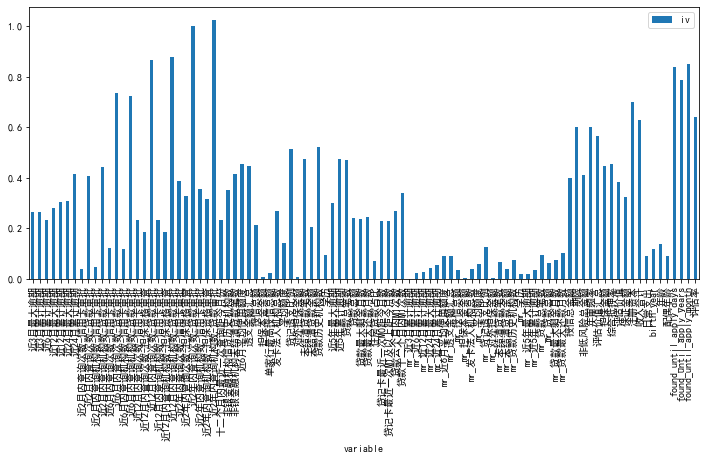

In [71]:
filter_fea_df.plot.bar(figsize=(12,5))

In [72]:
tra_x_woe.drop(rf_drop_feas,axis=1,inplace=True)
tra_x_woe.drop([i + '_woe' for i in adj_feas],axis=1,inplace=True)
test_x_woe.drop(rf_drop_feas,axis=1,inplace=True)
test_x_woe.drop([i + '_woe' for i in adj_feas],axis=1,inplace=True)

# 3. 特征筛选

In [73]:
import statsmodels.api as sm

# 显著性筛选,在筛选前需要做woe转换
def forward_delete_pvalue(x_train,y_train):
    """
    x_train -- x训练集
    y_train -- y训练集
    
    return :显著性筛选后的变量
    """
    col_list = list(x_train.columns)
    pvalues_col=[]
    for col in col_list:
        print(col)
        pvalues_col.append(col)
        x_train2 = sm.add_constant(x_train.loc[:,pvalues_col])
        sm_lr = sm.Logit(y_train,x_train2)
        try:
            sm_lr = sm_lr.fit()
        except:
            continue
        for i,j in zip(sm_lr.pvalues.index[1:],sm_lr.pvalues.values[1:]): 
            if j>=0.05:
                pvalues_col.remove(i)
    x_new_train = x_train.loc[:,pvalues_col]
    x_new_train2 = sm.add_constant(x_new_train)
    lr = sm.Logit(y_train,x_new_train2)
    lr = lr.fit()
    return pvalues_col

# xgboost筛选变量 
def select_xgboost(df,target,imp_num=None):
    """
    df:数据集
    target:目标变量的字段名
    imp_num:筛选变量的个数
    
    return:
    xg_fea_imp:变量的特征重要性
    xg_select_col:筛选出的变量
    """
    x = df.drop([target],axis=1)
    y = df[target]
    xgmodel = XGBClassifier(random_state=0)
    xgmodel = xgmodel.fit(x,y,eval_metric='auc')
    xg_fea_imp = pd.DataFrame({'col':list(x.columns),
                               'imp':xgmodel.feature_importances_})
    xg_fea_imp = xg_fea_imp.sort_values('imp',ascending=False).reset_index(drop=True).iloc[:imp_num,:]
    xg_select_col = list(xg_fea_imp.col)
    return xg_fea_imp,xg_select_col

# KS 
def plot_model_ks(y_label,y_pred):
    """
    y_label:测试集的y
    y_pred:对测试集预测后的概率
    
    return:KS曲线
    """
    pred_list = list(y_pred) 
    label_list = list(y_label)
    total_bad = sum(label_list)
    total_good = len(label_list)-total_bad 
    items = sorted(zip(pred_list,label_list),key=lambda x:x[0]) 
    step = (max(pred_list)-min(pred_list))/200 
    
    pred_bin=[]
    good_rate=[] 
    bad_rate=[] 
    ks_list = [] 
    for i in range(1,201): 
        idx = min(pred_list)+i*step 
        pred_bin.append(idx) 
        label_bin = [x[1] for x in items if x[0]<idx] 
        bad_num = sum(label_bin)
        good_num = len(label_bin)-bad_num  
        goodrate = good_num/total_good 
        badrate = bad_num/total_bad
        ks = abs(goodrate-badrate) 
        good_rate.append(goodrate)
        bad_rate.append(badrate)
        ks_list.append(ks)
    
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(1,1,1)
    ax.plot(pred_bin,good_rate,color='green',label='good_rate')
    ax.plot(pred_bin,bad_rate,color='red',label='bad_rate')
    ax.plot(pred_bin,ks_list,color='blue',label='good-bad')
    ax.set_title('KS:{:.3f}'.format(max(ks_list)))
    ax.legend(loc='best')
    return plt.show(ax)

def plot_roc(y_label,y_pred):
    """
    y_label:测试集的y
    y_pred:对测试集预测后的概率
    
    return:ROC曲线
    """
    tpr,fpr,threshold = roc_curve(y_label,y_pred) 
    AUC = roc_auc_score(y_label,y_pred) 
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(1,1,1)
    ax.plot(tpr,fpr,color='blue',label='AUC=%.3f'%AUC) 
    ax.plot([0,1],[0,1],'r--')
    ax.set_ylim(0,1)
    ax.set_xlim(0,1)
    ax.set_title('ROC')
    ax.legend(loc='best')
    return plt.show(ax)

In [74]:
tra_x_woe.loc[:,tra_x_woe.columns.str.contains('次数')] = tra_x_woe.fillna(0)
tra_x_woe.loc[:,['mr_征信白户']] = tra_x_woe.fillna(0)

In [75]:
test_x_woe.loc[:,test_x_woe.columns.str.contains('次数')] = test_x_woe.fillna(0)
test_x_woe.loc[:,['mr_征信白户']] = test_x_woe.fillna(0)

[INFO] creating woe binning ...


{'还款间隔': <Figure size 432x288 with 2 Axes>}

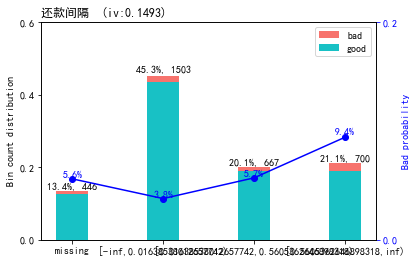

In [76]:
hkbin = sc.woebin(tra_x_woe,'tag',x='还款间隔')
sc.woebin_plot(hkbin)

In [77]:
# hkbin = sc.woebin(tra_x_woe,'tag',x='还款间隔',breaks_list={'还款间隔':['missing',12,np.inf]})
# tra_x_woe = sc.woebin_ply(tra_x_woe,hkbin)
# test_x_woe = sc.woebin_ply(test_x_woe,hkbin)

In [78]:
fs = FeatureSelector(tra_x_woe.drop('tag',axis=1),tra_x_woe['tag'])
fs.identify_single_unique()
drop_feas = fs.ops['single_unique']
fs.identify_collinear(0.7)
drop_feas.extend(fs.ops['collinear'])

14 features with a single unique value.

28 features with a correlation magnitude greater than 0.70.



In [79]:
if '非银金融机构信贷历史机构数_woe' in drop_feas:
    drop_feas.remove('非银金融机构信贷历史机构数_woe')

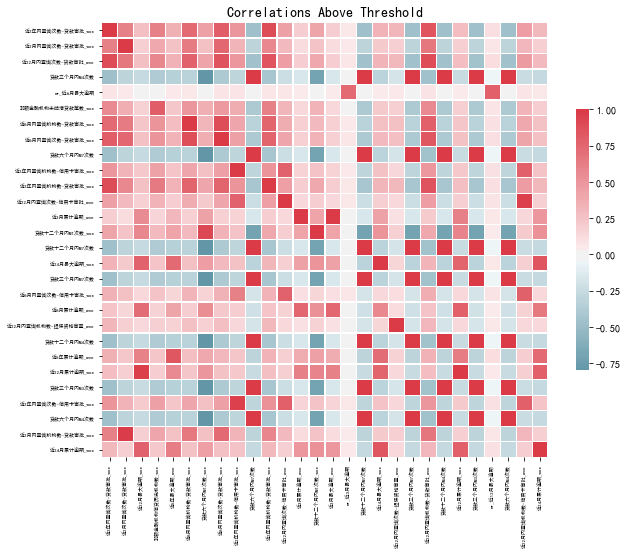

In [80]:
fs.plot_collinear()

In [81]:
tra_x_woe.drop(drop_feas,axis=1,inplace=True)
test_x_woe.drop(drop_feas,axis=1,inplace=True)

In [82]:
test_x_woe.shape

(2838, 19)

In [83]:
test_x_woe = test_x_woe.drop('tag',axis=1)
tra_x_woe = tra_x_woe.drop('tag',axis=1)
tra_x_woe.drop('还款间隔',axis=1,inplace=True)
test_x_woe.drop('还款间隔',axis=1,inplace=True)

In [84]:
tra_y = tra_y.sort_index()
tra_x_woe = tra_x_woe.sort_index()
test_y = test_y.sort_index()
test_x_woe = test_x_woe.sort_index()

In [85]:
step_remove_feas = forward_delete_pvalue(tra_x_woe,tra_y)
tra_x_woe.drop(step_remove_feas,axis=1,inplace=True)
test_x_woe.drop(step_remove_feas,axis=1,inplace=True)

work_place_equal_birth_place
Optimization terminated successfully.
         Current function value: 0.215959
         Iterations 7
是否保证加抵押
Optimization terminated successfully.
         Current function value: 0.213222
         Iterations 7
mr_征信白户
Optimization terminated successfully.
         Current function value: 0.213216
         Iterations 8
贷款三个月内M4次数
Optimization terminated successfully.
         Current function value: 0.211241
         Iterations 8
mr_近6月最大逾期
Optimization terminated successfully.
         Current function value: 0.210658
         Iterations 8
work_place_equal_resdnt_place
Optimization terminated successfully.
         Current function value: 0.210590
         Iterations 8
征信白户
Optimization terminated successfully.
         Current function value: 0.210478
         Iterations 8
近2年内查询次数-信用卡审批_woe
Optimization terminated successfully.
         Current function value: 0.203269
         Iterations 8
近6月累计逾期_woe
Optimization terminated successfully.
         Curr

In [86]:
xgmodel = XGBClassifier(random_state=123)
xgmodel = xgmodel.fit(tra_x_woe,tra_y,eval_metric='auc')
# xg_score = cross_val_score(xgmodel,tra_x_woe,tra_y,scoring='roc_auc',cv=10)
xg_fea_imp = pd.DataFrame({'col':list(tra_x_woe.columns),
                           'imp':xgmodel.feature_importances_})
xg_fea_imp = xg_fea_imp.sort_values('imp',ascending=False).set_index('col')
xg_select_col = list(xg_fea_imp.head(20).index)

In [87]:
tra_x_woe = tra_x_woe[xg_select_col]
test_x_woe = test_x_woe[xg_select_col]

In [88]:
test_x_woe_oot = test_x_woe.loc[test_x[test_x['oot']==1].index]
test_x_woe_dt = test_x_woe.loc[test_x[test_x['oot'] == 0].index]

In [89]:
test_x_woe_dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 829 entries, 7790 to 614
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   非银金融机构未结清贷款笔数_woe              829 non-null    float64
 1   近2月内查询机构数-贷款审批_woe             829 non-null    float64
 2   近2年内查询次数-信用卡审批_woe             829 non-null    float64
 3   贷款三个月内M4次数                     829 non-null    float64
 4   近6月累计逾期_woe                    829 non-null    float64
 5   近12月内查询机构数-担保资格审查_woe          829 non-null    float64
 6   非银金融机构信贷历史机构数_woe              829 non-null    float64
 7   近6月内查询次数-信用卡审批_woe             829 non-null    float64
 8   work_place_equal_resdnt_place  829 non-null    float64
 9   mr_近6月最大逾期                     829 non-null    float64
 10  mr_征信白户                        829 non-null    float64
 11  work_place_equal_birth_place   829 non-null    float64
 12  征信白户                           829 non-null    

In [90]:
test_y_dt = test_y.loc[test_x_woe_dt.index]

## 逻辑回归

In [92]:
lr_model = LogisticRegression(max_iter=200,random_state=123)
lr_model.fit(tra_x_woe,tra_y)

LogisticRegression(max_iter=200, random_state=123)

In [93]:
predict_score = lr_model.predict_proba(tra_x_woe)[:,1]

In [94]:
roc_auc_score(tra_y,predict_score)

0.7640523549417706

In [95]:
predict_test_score = lr_model.predict_proba(test_x_woe_oot)[:,1]
roc_auc_score(test_oot['tag'],predict_test_score)

0.8123199457719031

In [96]:
test_x_woe_dt = test_x_woe_dt.fillna(0)

In [97]:
predict_test_score_dt = lr_model.predict_proba(test_x_woe_dt)[:,1]
roc_auc_score(test_y_dt,predict_test_score_dt)

0.7423817815747946

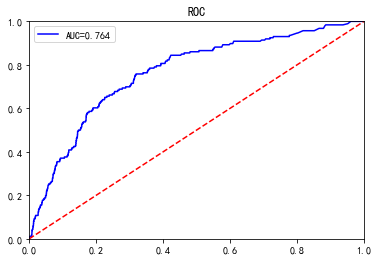

In [98]:
plot_roc(tra_y,predict_score)

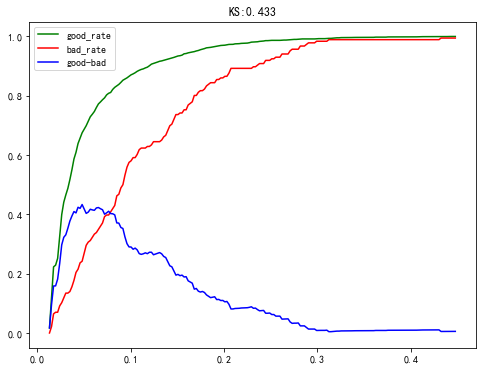

In [99]:
plot_model_ks(tra_y,predict_score)

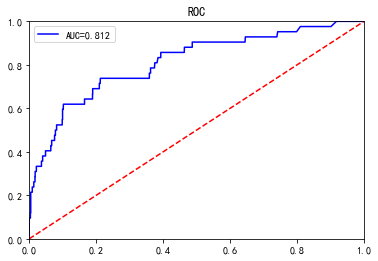

In [100]:
plot_roc(test_oot['tag'],predict_test_score)

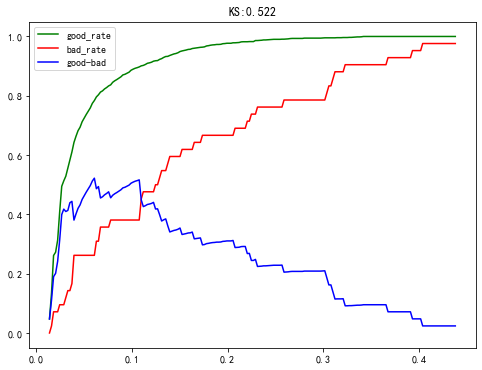

In [101]:
plot_model_ks(test_oot['tag'],predict_test_score)

In [ ]:
plot_model_ks(test_['tag'],predict_test_score)

In [102]:
tra_x_woe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3316 entries, 1 to 11506
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   非银金融机构未结清贷款笔数_woe              3316 non-null   float64
 1   近2月内查询机构数-贷款审批_woe             3316 non-null   float64
 2   近2年内查询次数-信用卡审批_woe             3316 non-null   float64
 3   贷款三个月内M4次数                     3316 non-null   float64
 4   近6月累计逾期_woe                    3316 non-null   float64
 5   近12月内查询机构数-担保资格审查_woe          3316 non-null   float64
 6   非银金融机构信贷历史机构数_woe              3316 non-null   float64
 7   近6月内查询次数-信用卡审批_woe             3316 non-null   float64
 8   work_place_equal_resdnt_place  3316 non-null   float64
 9   mr_近6月最大逾期                     3316 non-null   float64
 10  mr_征信白户                        3316 non-null   float64
 11  work_place_equal_birth_place   3316 non-null   float64
 12  征信白户                           3316 non-null   

In [103]:
# woe_feas = [i.split('_woe')[0] for i in tra_x_woe.loc[:,tra_x_woe.columns.str.contains('woe')].columns]
# filter_fea_df.reindex(woe_feas)